# Transfer Learning Using Pytorch

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from tqdm import tqdm
import time
import copy
from torch.utils.data import Dataset, Subset, random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from google.colab import drive
import os
from torchsummary import summary

drive.mount('/content/drive')
%matplotlib inline
%cd drive/MyDrive/MSDS\ Spring/deeplearning

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1eNAO8TfHfvKSUgq3DbaFUHpT7f4gcTwH/MSDS Spring/deeplearning


## Read and Explore Data

### Set device if using GPU

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Check for multiple gpus (I just came across this and wanted to have it in case i use it in the future, not using it during this hw)
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

cuda
1 gpus detected.


### Define functions and classes for data preprocessing

In [3]:
# Get mean and std
def getMeanStd(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Need to do this to add transformations to training but not to validation
class PrepData(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)
    
class PadImage(object):
    def __call__(self, img):

        width, height = transforms.functional.get_image_size(img) 
        
        if width > height:
            height_padding = ((width - height) // 2)
            img = transforms.functional.pad(img, [0, height_padding])
        else:
            width_padding = ((height - width) // 2)
            img = transforms.functional.pad(img, [width_padding, 0])           

        return img

    def __repr__(self):
        return self.__class__.__name__+'()'

### Get mean and standard deviation of train dataset to normalize our images (Only need to do this once so its commented out)

In [4]:
# # Parameters
# data_dir = "./content/dataset"
# batch_size = 64
# img_height = 224
# img_width = 224
# train_size = 0.85
# num_workers = 2

# # Basic transformation for loading to get mean and std of data set
# datatransform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((img_height, img_width))
# ])

# # Load dataset
# dataset = datasets.ImageFolder(data_dir, transform=datatransform)

# # Create the index splits for training, validation and test
# num_train = len(dataset)
# indices = list(range(num_train))
# split = int(np.floor(train_size * num_train))
# np.random.seed(1999)
# np.random.shuffle(indices)
# train_idx, valid_idx = indices[:split], indices[split:]

# # Get mean and std of training subset (before transformations) - dont want to use test and valid for this part
# traindataset = PrepData(dataset)
# traindata = Subset(traindataset, indices=train_idx)
# trainloader = DataLoader(traindata, batch_size=batch_size, num_workers=num_workers, drop_last=True)
# mean, std = getMeanStd(trainloader)

### Apply Preprocessing and take a look at the data we have

In [5]:
# Parameters
data_dir = "./content/dataset"
batch_size = 64
img_height = 224
img_width = 224
train_size = 0.85
num_workers = 2
mean = torch.tensor([0.4407, 0.4332, 0.4326])
std = torch.tensor([0.2520, 0.2610, 0.2906])

# Basic transformation for loading to get mean and std of data set

dataset = datasets.ImageFolder(data_dir)

# Create the index splits for training, validation and test (test we dont have any for this)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.seed(1999)
np.random.shuffle(indices)
train_idx, valid_idx = indices[:split], indices[split:]

# Set transforms
traintransform = transforms.Compose([
    transforms.ToTensor(),
    PadImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ColorJitter(brightness=0.01),
    transforms.RandomAffine(degrees = 10, shear = 45),
    transforms.Normalize(mean, std)
])

testtransform = transforms.Compose([
    transforms.ToTensor(),
    PadImage(),
    transforms.Resize((img_height, img_width)),
    transforms.Normalize(mean, std)
])

# Apply transformations
traindataset = PrepData(dataset,traintransform)
valdataset = PrepData(dataset,testtransform)

# Use same subset as above
traindata = Subset(traindataset, indices=train_idx)
valdata = Subset(valdataset, indices=valid_idx)


trainloader = DataLoader(traindata, batch_size=batch_size,
                         num_workers=num_workers, drop_last=True)
validloader = DataLoader(valdata, batch_size=batch_size,
                         num_workers=num_workers, drop_last=True)


### Visualize what our data looks like after transformations are applied

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


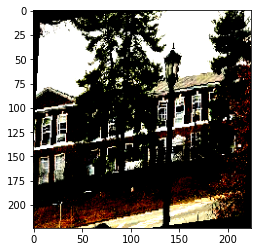

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.imshow(np.transpose(images[1].cpu().detach().numpy(), (1, 2, 0)))

### Get Classes and count of classes to see if they are imbalanced

In [7]:
classes = sorted([x[0][len(data_dir) + 1:] for x in os.walk(data_dir)][1:])

class_count = dict(zip(classes, torch.unique(torch.tensor(dataset.targets), return_counts=True)[1].tolist()))

class_count

{'AcademicalVillage': 408,
 'AldermanLibrary': 742,
 'AlumniHall': 457,
 'AquaticFitnessCenter': 556,
 'BravoHall': 200,
 'BrooksHall': 410,
 'ClarkHall': 849,
 'MadisonHall': 368,
 'MinorHall': 760,
 'NewCabellHall': 636,
 'NewcombHall': 716,
 'OldCabellHall': 832,
 'OlssonHall': 995,
 'RiceHall': 1460,
 'Rotunda': 1569,
 'ScottStadium': 1257,
 'ThorntonHall': 1219,
 'UniversityChapel': 857}

### Define model and get its summary

In [8]:
model = torchvision.models.regnet_y_16gf(pretrained=True)

# Freeze all the layers bar the last one
# for param in model.parameters():
#     param.requires_grad = False

output_units = len(class_count)
    
# Change the number of output units
model.fc = nn.Linear(3024, output_units)

# print summary (commented out because its long)
# summary(model.to(device),
#     input_size=(3, img_height, img_width), 
#     batch_size=batch_size, 
#     device='cuda')


Downloading: "https://download.pytorch.org/models/regnet_y_16gf-9e6ed7dd.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_16gf-9e6ed7dd.pth


  0%|          | 0.00/319M [00:00<?, ?B/s]

### Make sure model overfits on a small amount of data (one batch)

In [9]:
# Network
model = model.to(device) 

#just in case i want to use multiple gpus (this is for my own personal use, not using it in this class)
if multi_gpu:
    model = nn.DataParallel(model)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 100

data, targets = next(iter(trainloader))

# Train Network
for epoch in range(num_epochs):
    losses = []
    data = data.to(device=device)
    targets = targets.to(device=device)

    # forward
    scores = model(data)
    loss = criterion(scores, targets)

    losses.append(loss.item())
    
    # backward
    optimizer.zero_grad()
    loss.backward()

    # gradient descent or adam step
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


Cost at epoch 0 is 2.86258
Cost at epoch 10 is 2.12791
Cost at epoch 20 is 1.55923
Cost at epoch 30 is 1.09628
Cost at epoch 40 is 0.75821
Cost at epoch 50 is 0.53022
Cost at epoch 60 is 0.38205
Cost at epoch 70 is 0.28617
Cost at epoch 80 is 0.22287
Cost at epoch 90 is 0.17961


## Training

### Define Functions For Training

In [9]:
# Define functions
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

def train_one_epoch(loader, model, optimizer, loss_fn, scaler, device):
    for batch_idx, (data, targets) in enumerate(tqdm(loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        with torch.cuda.amp.autocast():
            scores = model(data)
            loss = loss_fn(scores, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

def get_loss_accuracy(loader, model, loss_fn):
    num_correct = 0
    num_samples = 0

    running_loss = 0
    mean_loss = 0

    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)

            # update loss
            loss = loss_fn(scores, y)
            running_loss += loss.item()
            mean_loss = running_loss/(i+1)

            # update
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    accuracy = float(num_correct) / float(num_samples) * 100

    print(f'Loss: {mean_loss}')
    print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')

    model.train()

    return mean_loss, accuracy

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}')

    model.train()

# Define Classes

class EarlyStopping():
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs
        self.current_epochs = 0
        self.best_loss = np.inf

    def __call__(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.current_epochs = 0
        else:
            self.current_epochs += 1
            if self.current_epochs >= self.max_epochs:
                print("Early Stopping!")
                return True

class SaveBestModel():
    def __init__(self):
        self.best_valid_loss = np.inf
        self.best_model = None
        
    def __call__(self, current_valid_loss, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_model = model
            self.best_valid_loss = current_valid_loss
            print(f"Best validation loss: {self.best_valid_loss}")
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint, filename='best_model.pth')
        return self.best_model


### Train Model

In [17]:
## Define Hyperparameters
model = model.to(device)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()
early_stopping = EarlyStopping(max_epochs = 3)
save_best_model = SaveBestModel()

## Train Model
for epoch in range(epochs): 
    train_one_epoch(trainloader, model, optimizer, loss_fn, scaler, device)
    valid_loss, valid_accuracy = get_loss_accuracy(validloader, model, loss_fn)
    best_model = save_best_model(valid_loss, model, optimizer)
    if early_stopping(valid_loss): break
    print(50 * '-')

100%|██████████| 189/189 [07:43<00:00,  2.45s/it]


Loss: 0.5207281618407278
Got 1813 / 2112 with accuracy 85.84
Best validation loss: 0.5207281618407278
=> Saving checkpoint
--------------------------------------------------


100%|██████████| 189/189 [07:43<00:00,  2.45s/it]


Loss: 0.39420453346136847
Got 1894 / 2112 with accuracy 89.68
Best validation loss: 0.39420453346136847
=> Saving checkpoint
--------------------------------------------------


100%|██████████| 189/189 [07:43<00:00,  2.45s/it]


Loss: 0.3432330150495876
Got 1920 / 2112 with accuracy 90.91
Best validation loss: 0.3432330150495876
=> Saving checkpoint
--------------------------------------------------


100%|██████████| 189/189 [07:43<00:00,  2.45s/it]


Loss: 0.3180406294537313
Got 1944 / 2112 with accuracy 92.05
Best validation loss: 0.3180406294537313
=> Saving checkpoint
--------------------------------------------------


100%|██████████| 189/189 [07:43<00:00,  2.45s/it]


Loss: 0.4523882418870926
Got 1904 / 2112 with accuracy 90.15
--------------------------------------------------


100%|██████████| 189/189 [07:43<00:00,  2.45s/it]


Loss: 0.3475282314148816
Got 1952 / 2112 with accuracy 92.42
--------------------------------------------------


100%|██████████| 189/189 [07:43<00:00,  2.45s/it]


Loss: 0.41245486745328613
Got 1921 / 2112 with accuracy 90.96
Early Stopping!


### Check Model Accuracy

In [16]:
# Load model
checkpoint = torch.load('best_model.pth')

# Model
model = torchvision.models.regnet_y_16gf(pretrained=True)
output_units = len(class_count)
model.fc = nn.Linear(3024, output_units)
best_model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)

# Load Checkpoint
load_checkpoint(checkpoint, best_model, optimizer)

=> Loading checkpoint


In [17]:
check_accuracy(validloader, best_model)

Got 1944 / 2112 with accuracy 92.05
